In [1]:
import numpy as np
import pandas as pd
import scipy as scp
import matplotlib.pyplot as plt
import math
import matplotlib.cm as cmx
from src.mssm.models import *
np.set_printoptions(suppress=True)

## semi-Markov switching GAMMs


In [2]:
# This is an example of the most general models that can be estimated with this method:
# A semi-Markov switching Generalized additive mixed model. Such a model permits for
# the relationship between the covariates and our signal to differ per state. Additionally,
# random effects can also differ per stage. Finally, the noise in the signal can also
# differ per stage.

# An accessible introduction to Markov switching GAMs is provided by Langrock et al., 2017.
# Haji-Maghsoudi et al., 2021 discuss how semi-Markov switching Generalized linear mixed models can
# be estimated. They sample random effects in addition to state sequences. Because we exploit the link
# between smoothing penalties and random effect variance terms (Wood, 2017) we don't need such an extra step - rather
# we estimate random effects directly from a sampled state sequence.

In [3]:
# Initializing function - basically just sample from a HsMM with the intialized
# parameters.
def prop_states_init(n_t,n_j,pi,T,ps):
   state_durs = []
   states = []

   # Select first state based on pi - initial state distribution
   c_state = np.random.choice(list(range(n_j)))

   # Duration of state is then sampled (at every transition independently!)
   # from the sojourn time distribution of the selected state.
   c_dur = min(int(ps[c_state].rvs()),n_t)
   
   state_durs.append([c_state,c_dur])

   # We remain in that state for duration c_dur
   for _ in range(c_dur):
      states.append(c_state)

   t = c_dur

   # Now we transition!
   while t < n_t:
      remaining_j = list(range(n_j))
      
      # Pick the next state based on it's row in T - the transition
      # probabilities
      c_state = np.random.choice(remaining_j,p=T[c_state,:])

      # Then repeat.
      c_dur = min(int(ps[c_state].rvs()),n_t)

      if t + c_dur > n_t:
         c_dur -= (t + c_dur - n_t)
      
      state_durs.append([c_state,c_dur])

      for _ in range(c_dur):
          states.append(c_state)

      t += c_dur

   return np.array(state_durs), np.array(states)

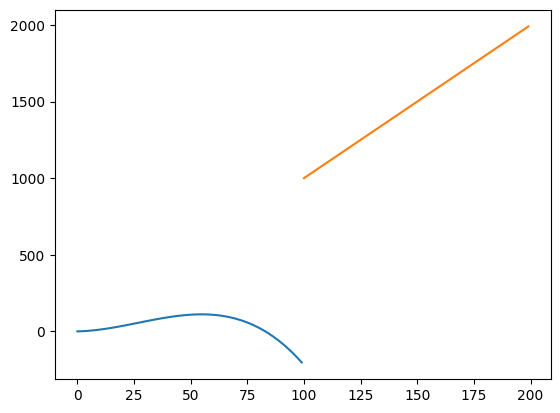

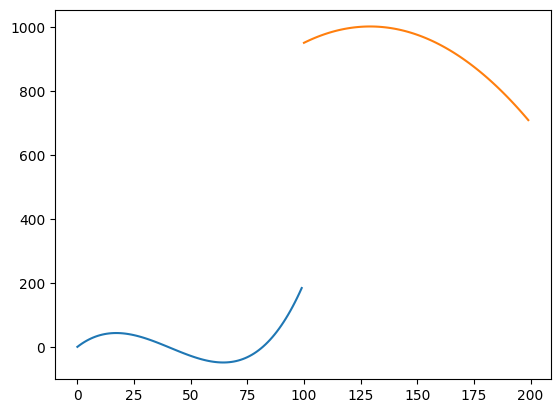

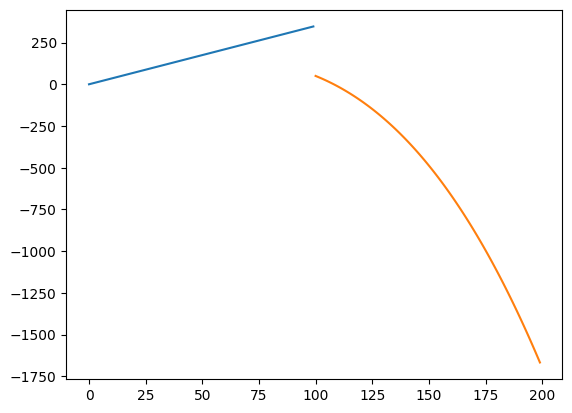

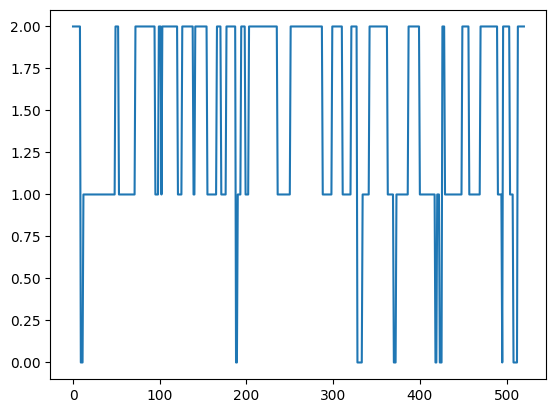

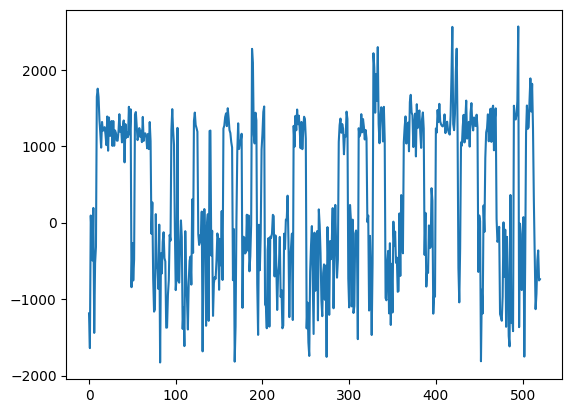

37


In [4]:
# Sim from a sms GAMM with multiple covariates and random intercepts.
# Basically like the initializer but this time we also simulate covariates
# and then the response variable according to some function of the covariates
# that can differ per state!
# Then we also simulate some random intercepts for every series we simulate.
n_s = 10

# Simulation parameters
scales = [2,5,7]

pi = [0.1,0.7,0.2]

sds = [150,150,150]

rand_sds = [300,450,200]

rand_ints = np.array([scp.stats.norm.rvs(loc=0,scale=rand_sds[j],size=n_s) for j in range(len(rand_sds))])

T = np.array([[0.0,0.7,0.3],
              [0.4,0.0,0.6],
              [0.3,0.7,0.0]])

n_transitions = 50

# Covariates
x = np.array(list(range(100)))
z = np.array(list(range(100,200)))

t_states = []
t_state_durs = []
t_endpoints= []
t_cov = [[],[],[]]
t_time = []
t_y = []

# The relationships between y and x,z for every state!
plt.plot(x, 0.3*x + 0.1*x**2 - 0.00125*x**3)
plt.plot(z, 10*z)
plt.show()

plt.plot(x, 5.5*x - 0.2*x**2 + 0.0015*x**3 + 0.0000015*x**4)
plt.plot(z, 15.5*z - 0.06*z**2)
plt.show()

plt.plot(x, 3.5*x)
plt.plot(z, 3.5*z - 0.0003*z**3)
plt.show()

for s in range(n_s):

    states = []
    state_durs = []
    cov = []
    time = []
    y = []

    t = 0

    c_state = np.random.choice([0,1,2],p=pi)
    c_dur = int(scp.stats.gamma.rvs(a=2, scale=scales[c_state],size=1)[0]+0.5)
    state_durs.append([c_state,c_dur])
    for d in range(c_dur):
        states.append(c_state)
        time.append(t)
        c_cov_x = np.random.choice(x,size=1)[0]
        c_cov_z = np.random.choice(z,size=1)[0]
        cov.append([c_cov_x,c_cov_z,s])

        if c_state == 0:
            c_y = 60 + 0.3*c_cov_x + 0.1*c_cov_x**2 - 0.00125*c_cov_x**3
            c_y += 10*c_cov_z
        elif c_state == 1:
            c_y = -15 + 5.5*c_cov_x - 0.2*c_cov_x**2 + 0.0015*c_cov_x**3 + 0.0000015*c_cov_x**4
            c_y += 15.5*c_cov_z - 0.06*c_cov_z**2
        else:
            c_y = 30 + 3.5*c_cov_x
            c_y += 3.5*c_cov_z - 0.0003*c_cov_z**3
        c_y += rand_ints[c_state,s] # Random intercept for current state and s
        c_y += scp.stats.norm.rvs(scale=sds[c_state],size=1)[0]
        y.append(c_y)
        t += 1

    for nt in range(n_transitions):
        c_state = np.random.choice([0,1,2],p=T[c_state,:])
        c_dur = int(scp.stats.gamma.rvs(a=2, scale=scales[c_state],size=1)[0]+0.5)
        state_durs.append([c_state,c_dur])
        for d in range(c_dur):
            states.append(c_state)
            time.append(t)
            c_cov_x = np.random.choice(x,size=1)[0]
            c_cov_z = np.random.choice(z,size=1)[0]
            cov.append([c_cov_x,c_cov_z,s])

            if c_state == 0:
                c_y = 60 + 0.3*c_cov_x + 0.1*c_cov_x**2 - 0.00125*c_cov_x**3
                c_y += 10*c_cov_z
            elif c_state == 1:
                c_y = -15 + 5.5*c_cov_x - 0.2*c_cov_x**2 + 0.0015*c_cov_x**3 + 0.0000015*c_cov_x**4
                c_y += 15.5*c_cov_z - 0.06*c_cov_z**2
            else:
                c_y = 30 + 3.5*c_cov_x
                c_y += 3.5*c_cov_z - 0.0003*c_cov_z**3
            c_y += rand_ints[c_state,s] # Random intercept for current state and s
            c_y += scp.stats.norm.rvs(scale=sds[c_state],size=1)[0]
            y.append(c_y)
            t += 1

    cov = np.array(cov)
    time = np.array(time)
    states = np.array(states)
    state_durs = np.array(state_durs)
    y = np.array(y)

    if s == 0:
        plt.plot(time,states)
        plt.show()
        plt.plot(time,y)
        plt.show()
        print(max(state_durs[:,1]))

    t_states.extend(states)
    t_state_durs.append(state_durs)
    for cshape in range(cov.shape[1]):
        t_cov[cshape].extend(cov[:,cshape])
    t_time.extend(time)
    t_endpoints.append(time[-1])
    t_y.extend(y)
t_endpoints = np.array(t_endpoints)

In [5]:
data = pd.DataFrame({"y":t_y,"x":t_cov[0],"z":t_cov[1],"series":t_cov[2],"time":t_time,"states":t_states})
data = data.astype({'series': 'O'})

In [6]:
data

,y,x,z,series,time,states
0,-1186.547409,99,186,0,0,2
1,-1641.100505,91,199,0,1,2
2,93.512876,96,115,0,2,2
3,-165.722527,37,147,0,3,2
4,-495.420454,60,167,0,4,2
...,...,...,...,...,...,...
5044,956.649643,41,121,9,542,1
5045,739.728785,25,196,9,543,1
5046,643.382853,25,199,9,544,1
5047,1202.819852,45,129,9,545,1


In [7]:
# Try and recover the simulated data:
formula = Formula(lhs("y"),
                  [i(),
                   f(["x"],nk=10),
                   f(["z"],nk=10),
                   ri("series")],
                   n_j=3,
                   data=data,
                   split_scale=True,
                   series_id="series")

pformula = PFormula([PTerm(scp.stats.gamma,{"a":2,"scale":15},{"fa":2,"floc":0}),
                     PTerm(scp.stats.gamma,{"a":2,"scale":15},{"fa":2,"floc":0}),
                     PTerm(scp.stats.gamma,{"a":2,"scale":15},{"fa":2,"floc":0})])

model = sMsGAMM(formula,Gaussian(),pformula,t_endpoints,cpus=4)

/Users/joshmac/Documents/repos/mssm/src/mssm/src/python/formula.py:320: UserWarning: split_scale==True! All terms will be estimted per latent stage, independent of terms' by_latent status.
  warnings.warn("split_scale==True! All terms will be estimted per latent stage, independent of terms' by_latent status.")


In [8]:
llk_hist,states = model.fit()

Converged 60


In [9]:
state_coef,state_scales,TR,pi = model.get_pars()

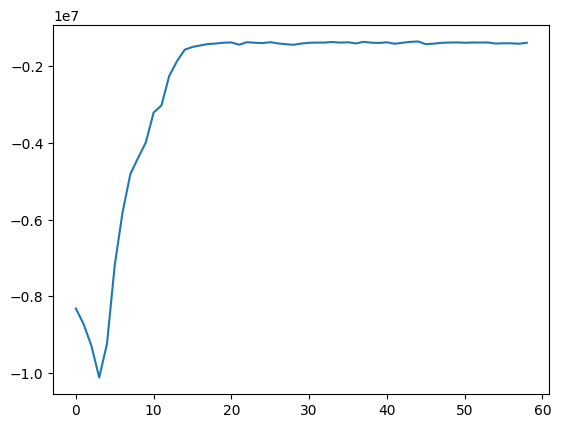

In [10]:
plt.plot(llk_hist)
plt.show()

In [11]:
data["state_est"] = states # ToDo: These could probably benefit from global decoding using the final parameters..

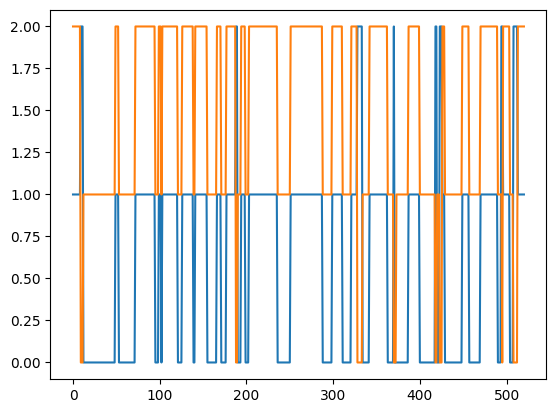

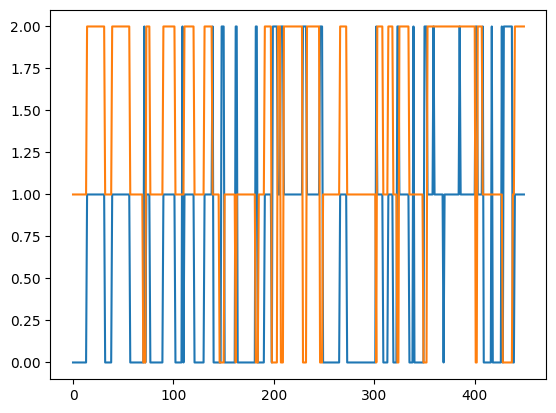

In [12]:
for s in np.unique(data["series"])[0:2]:
    plt.plot(data["time"][data["series"] == s],
            data["state_est"][data["series"] == s])
    plt.plot(data["time"][data["series"] == s],
             data["states"][data["series"] == s])
    plt.show()

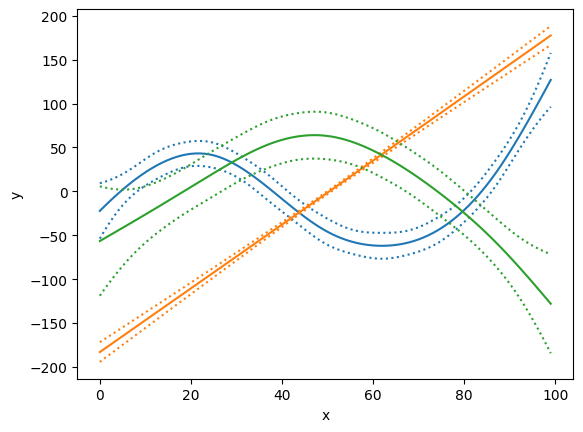

In [13]:
# Prediction for effect of x for all states
nc = 10
colors = [cmx.tab20(x) for x in np.linspace(0.0,min(0.1*nc,1.0),nc)]

for si in range(3):
    # Set up some new data for prediction
    x_pred = [v for v in range(0,100,1)]
    z_pred = [v for v in range(100,200,1)]
    new_dat = pd.DataFrame({"x":x_pred,
                            "z":z_pred,
                            "series":[0 for _ in range(len(x_pred))]})
    
    # Make prediction using random smooth terms only
    pred,_,b = model.predict(si,[1],new_dat,ci=True,alpha=0.05)
    plt.plot(x_pred,pred,color=colors[si])
    plt.plot(x_pred,pred+b,color=colors[si], linestyle='dotted')
    plt.plot(x_pred,pred-b,color=colors[si], linestyle='dotted')

plt.xlabel("x")
plt.ylabel("y")
plt.show()

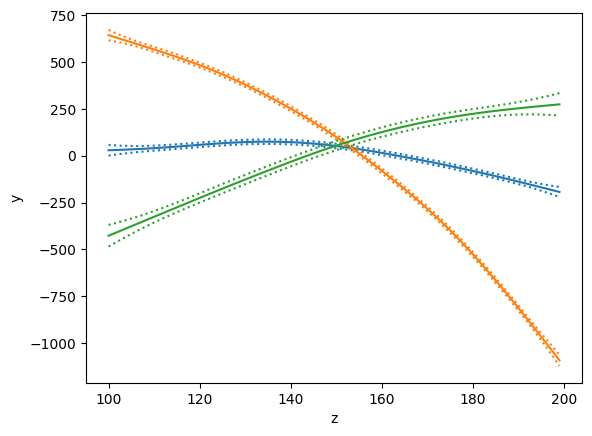

In [14]:
# Prediction for effect of z for all states
nc = 10
colors = [cmx.tab20(x) for x in np.linspace(0.0,min(0.1*nc,1.0),nc)]

for si in range(3):
    # Set up some new data for prediction
    x_pred = [v for v in range(0,100,1)]
    z_pred = [v for v in range(100,200,1)]
    new_dat = pd.DataFrame({"x":x_pred,
                            "z":z_pred,
                            "series":[0 for _ in range(len(x_pred))]})
    
    # Make prediction using random smooth terms only
    pred,_,b = model.predict(si,[2],new_dat,ci=True,alpha=0.05)
    plt.plot(z_pred,pred,color=colors[si])
    plt.plot(z_pred,pred+b,color=colors[si], linestyle='dotted')
    plt.plot(z_pred,pred-b,color=colors[si], linestyle='dotted')

plt.xlabel("z")
plt.ylabel("y")
plt.show()